# MARBLE Training Example with Time-Aligned EEG Data

This notebook demonstrates how to use the functions in `data_processing.py` to train MARBLE models on EEG data with time-aligned labels.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
from glob import glob
import mne
import torch

import MARBLE
from MARBLE import postprocessing, plotting

from data_processing import (
    parse_timestamp_from_filename,
    generate_time_array,
    load_merged_data,
    prepare_MARBLE_data,
    train_MARBLE_model
)

/home/honglab/leijiaxin/anaconda3/envs/MARBLE/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Example 3: Load and process EEG data

Now let's load some EEG data from files and process it for MARBLE.

Loading file: 2024_08_16_00_00_00_bipolar.fif
Setting reference time to: 2024-08-16 07:00:00


/home/honglab/leijiaxin/MARBLE/data_processing.py:163: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_16_00_00_00_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


Loaded data shape: (200000, 6)
Time array shape: (200000,)
Used 1 file(s)
Next file index: 1
Remainder data: (6, 4203400)


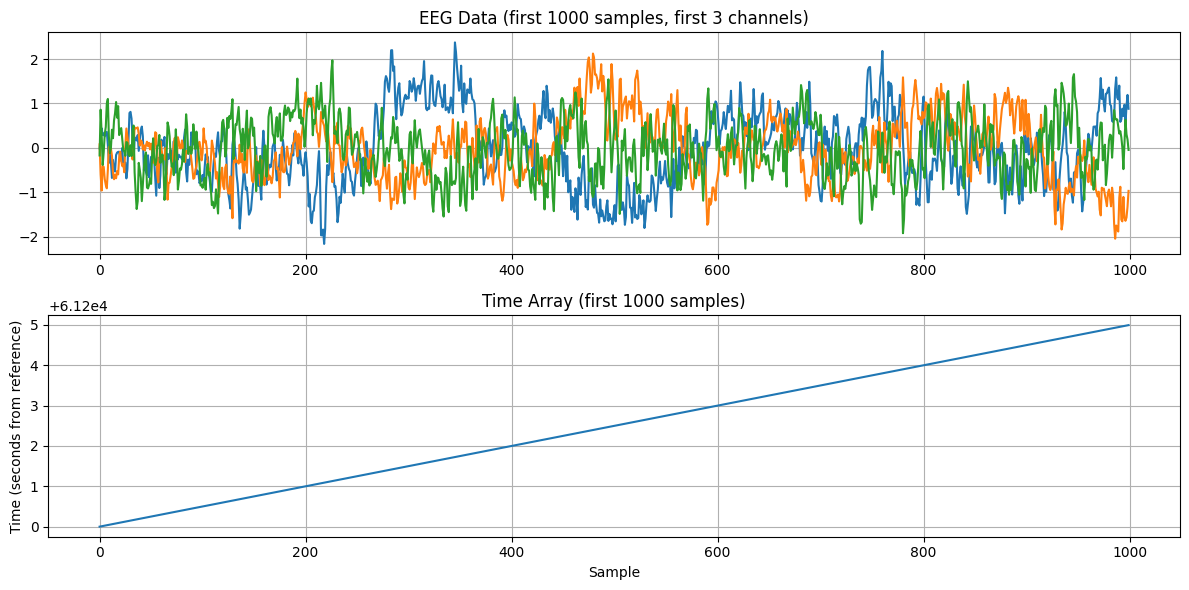

In [4]:
# Define parameters
data_dir = "./preprocessed/bipolar"
max_samples = 500000  # Use a smaller number for demonstration
resample_freq = 200

# Load data
batch_data, batch_times, used_files, next_file_idx, remainder_data, remainder_times = load_merged_data(
    data_dir=data_dir,
    max_samples=max_samples,
    resample_freq=resample_freq
)

print(f"Loaded data shape: {batch_data.shape}")
print(f"Time array shape: {batch_times.shape}")
print(f"Used {len(used_files)} file(s)")
print(f"Next file index: {next_file_idx}")
print(f"Remainder data: {'None' if remainder_data is None else remainder_data.shape}")

# Plot a sample of the data
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(batch_data[:1000, :3])
plt.title('EEG Data (first 1000 samples, first 3 channels)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(batch_times[:1000])
plt.title('Time Array (first 1000 samples)')
plt.xlabel('Sample')
plt.ylabel('Time (seconds from reference)')
plt.grid(True)
plt.tight_layout()
plt.show()

## Example 4: Prepare data for MARBLE

In [5]:
# Prepare data for MARBLE
pos_list, x_list, labels = prepare_MARBLE_data(batch_data, batch_times)

print(f"Position list shape: {pos_list.shape}")
print(f"Vector list shape: {x_list.shape}")
print(f"Labels shape: {labels.shape}")

Position list shape: (199999, 6)
Vector list shape: (199999, 6)
Labels shape: (199999,)


In [6]:
batch_times

array([61200.   , 61200.005, 61200.01 , ..., 62199.985, 62199.99 ,
       62199.995])

## Example 5: Train a MARBLE model with time labels

In [7]:
# Define MARBLE parameters
params = {
    "epochs": 100,  # Use fewer epochs for demonstration
    "order": 1,
    "hidden_channels": [256],
    "batch_size": 256,
    "lr": 1e-3,
    "out_channels": 3,
    "inner_product_features": False,
    "emb_norm": True,
    "diffusion": True,
}

# Construct dataset
k_value = 20
Dataset = MARBLE.construct_dataset(
    anchor=pos_list, 
    vector=x_list,
    label=labels,  # Use time-based labels
    graph_type="cknn",
    k=k_value,  
    spacing=0.05,
)

# Train model
model = MARBLE.net(Dataset, params=params)
model.fit(Dataset)

# Transform data
transformed_data = model.transform(Dataset)
transformed_data = postprocessing.embed_in_2D(transformed_data)


---- Embedding dimension: 6
---- Signal dimension: 6
---- Computing kernels ... 
---- Computing full spectrum ...
              (if this takes too long, then run construct_dataset()
              with number_of_eigenvectors specified) 
---- Settings: 

epochs : 100
order : 1
hidden_channels : [256]
batch_size : 256
lr : 0.001
out_channels : 3
inner_product_features : False
emb_norm : True
diffusion : True
momentum : 0.9
dropout : 0.0
batch_norm : batch_norm
bias : True
frac_sampled_nb : -1
include_positions : False
include_self : True
vec_norm : False
seed : 0
dim_signal : 6
dim_emb : 6
n_sampled_nb : -1

---- Number of features to pass to the MLP:  42
---- Total number of parameters:  12292

Using device cuda:0

---- Training network ...

---- Timestamp: 20250324-205000

Epoch: 0, Training loss: 1.384246, Validation loss: 1.3744, lr: 0.0010 *
Epoch: 1, Training loss: 1.375381, Validation loss: 1.3161, lr: 0.0010 *
Epoch: 2, Training loss: 1.374465, Validation loss: 1.4489, lr: 0.0010

/home/honglab/leijiaxin/anaconda3/envs/MARBLE/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Performed umap embedding on embedded results.


## Example 6: Visualize results with time-based coloring

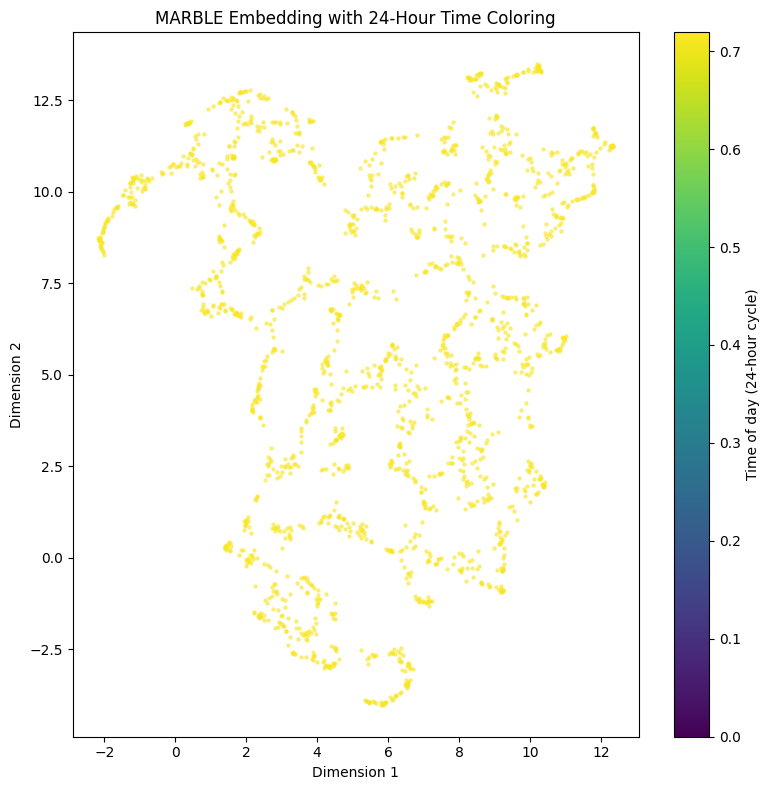

In [8]:
## Example 6: Visualize results with time-based coloring using MARBLE plotting

# Import the plotting module
from MARBLE import plotting

# Convert time array to normalized format for coloring
# The plotting function expects normalized values between 0-1 for the colormap
# Ensure the time labels represent a 24-hour cycle (86400 seconds)
normalized_times = (transformed_data.label.numpy() % 86400) / 86400

# Create a figure
plt.figure(figsize=(8, 8))
ax = plt.gca()

# Use MARBLE's plotting.embedding function
plotting.embedding(
    data=transformed_data,  # The 2D embedded data
    labels=normalized_times,  # Normalized time values for coloring (24-hour cycle)
    ax=ax,                   # Use the current axis
    alpha=0.5,               # Opacity of points
    s=5,                     # Size of points
    axes_visible=True,       # Show axes
    cbar_visible=True,       # Show colorbar
    cmap="viridis",          # Use Blues colormap
    time_gradient=True,      # Enable time gradient coloring
    style="o",               # Use scatter plot style
)

# Set title and labels
ax.set_title('MARBLE Embedding with 24-Hour Time Coloring')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')

# Add a custom colorbar label to reflect 24-hour time
cbar = plt.gcf().axes[-1]  # Get the colorbar axes
cbar.set_ylabel('Time of day (24-hour cycle)')

plt.tight_layout()
plt.show()

## Example 7: Use the train_MARBLE_model function for end-to-end processing

In [9]:
# Define parameters
data_dir = "./preprocessed/bipolar"
max_samples = 50000  # Use a smaller number for demonstration
resample_freq = 200
k_value = 20

# Define a reference time (7:00 AM on a placeholder date)
reference_time = datetime.datetime(2000, 1, 1, 7, 0, 0)

# Train model(s)
models, transformed_data_list = train_MARBLE_model(
    data_dir=data_dir,
    max_samples=max_samples,
    resample_freq=resample_freq,
    k_value=k_value,
    reference_time=reference_time,
    process_all_batches=False  # Just process one batch for demonstration
)

print(f"Trained {len(models)} model(s)")

Loading file: 2024_08_16_00_00_00_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:163: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_16_00_00_00_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


Batch 0: Loaded data with shape (50000, 6)

---- Embedding dimension: 6
---- Signal dimension: 6
---- Computing kernels ... 
---- Computing full spectrum ...
              (if this takes too long, then run construct_dataset()
              with number_of_eigenvectors specified) 
---- Settings: 

epochs : 50
order : 1
hidden_channels : [256]
batch_size : 256
lr : 0.001
out_channels : 3
inner_product_features : False
emb_norm : True
diffusion : True
momentum : 0.9
dropout : 0.0
batch_norm : batch_norm
bias : True
frac_sampled_nb : -1
include_positions : False
include_self : True
vec_norm : False
seed : 0
dim_signal : 6
dim_emb : 6
n_sampled_nb : -1

---- Number of features to pass to the MLP:  42
---- Total number of parameters:  12292

Using device cuda:0

---- Training network ...

---- Timestamp: 20250324-205125

Epoch: 0, Training loss: 1.437717, Validation loss: 1.4347, lr: 0.0010 *
Epoch: 1, Training loss: 1.400708, Validation loss: 1.3275, lr: 0.0010 *
Epoch: 2, Training loss: 1.3

/home/honglab/leijiaxin/anaconda3/envs/MARBLE/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Performed umap embedding on embedded results.
Trained 1 model(s)


## Example 8: Visualize results from batch processing

In [10]:
# Plot results for each batch
for i, (model, transformed_data) in enumerate(zip(models, transformed_data_list)):
    plt.figure(figsize=(12, 10))
    
    # Create a scatter plot with time-based coloring
    scatter = plt.scatter(
        transformed_data[:, 0],
        transformed_data[:, 1],
        c=model.data.label.numpy(),
        cmap='viridis',
        alpha=0.5,
        s=5
    )
    
    # Add colorbar to show time progression
    cbar = plt.colorbar(scatter)
    cbar.set_label('Time (seconds from reference)')
    
    # Set title and labels
    plt.title(f'MARBLE Embedding - Batch {i}')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

ValueError: only one element tensors can be converted to Python scalars

<Figure size 1200x1000 with 0 Axes>